In [1]:
# import openai
# import time 
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
import re
# %matplotlib inlinew2v_model
# from rake_nltk import Rake
import multiprocessing
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
# import seaborn as sns
# sns.set_style("darkgrid")

# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
import spacy
# import gensim
# from collections import defaultdict
from tqdm import tqdm

idea: 
    find concept pairs with similar embedding but no co-occ
    track over years

In [2]:
# s = "abcde(ab(abcde)abcde)abcde"


# def findOccurrences(s, ch):
#     return [i for i, letter in enumerate(s) if letter == ch]

# def remove_latex_math_formulas(text):
#     # Remove formulas enclosed in $...$
#     pattern_single = r"\$.*?\$"
#     text = re.sub(pattern_single, "<lTx>", text)
    
#     # Remove formulas enclosed in $$...$$
#     pattern_double = r"\$\$.*?\$\$"
#     text = re.sub(pattern_double, "<lTx>", text)

#     return text

# def tsnescatterplot(model, word, list_names, dim):
#     """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
#     its list of most similar words, and a list of words.
#     """
#     arrays = np.empty((0, 200), dtype='f')
#     word_labels = [word]
#     color_list  = ['red']

#     # adds the vector of the query word
#     arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
#     # gets list of most similar words
#     close_words = model.wv.most_similar([word])
    
#     # adds the vector for each of the closest words to the array
#     for wrd_score in close_words:
#         wrd_vector = model.wv.__getitem__([wrd_score[0]])
#         word_labels.append(wrd_score[0])
#         color_list.append('blue')
#         arrays = np.append(arrays, wrd_vector, axis=0)
    
#     # adds the vector for each of the words from list_names to the array
#     for wrd in list_names:
#         wrd_vector = model.wv.__getitem__([wrd])
#         word_labels.append(wrd)
#         color_list.append('green')
#         arrays = np.append(arrays, wrd_vector, axis=0)
        
#     # Reduces the dimensionality from 300 to 50 dimensions with PCA
#     reduc = PCA(n_components=dim).fit_transform(arrays)
    
#     # Finds t-SNE coordinates for 2 dimensions
#     np.set_printoptions(suppress=True)
    
#     Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
#     # Sets everything up to plot
#     df = pd.DataFrame({'x': [x for x in Y[:, 0]],
#                        'y': [y for y in Y[:, 1]],
#                        'words': word_labels,
#                        'color': color_list})
    
#     fig, _ = plt.subplots()
#     fig.set_size_inches(9, 9)
    
#     # Basic plot
#     p1 = sns.regplot(data=df,
#                      x="x",
#                      y="y",
#                      fit_reg=False,
#                      marker="o",
#                      scatter_kws={'s': 40,
#                                   'facecolors': df['color']
#                                  }
#                     )
    
#     # Adds annotations one by one with a loop
#     for line in range(0, df.shape[0]):
#          p1.text(df["x"][line],
#                  df['y'][line],
#                  '  ' + df["words"][line].title(),
#                  horizontalalignment='left',
#                  verticalalignment='bottom', size='medium',
#                  color=df['color'][line],
#                  weight='normal'
#                 ).set_size(15)

    
#     plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
#     plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
#     plt.title('t-SNE visualization for {}'.format(word.title()))

The goal of this notebook is to process the arxiv dataset into a suitable format for us. 
This included the following steps:
- Only process abstracts from the "quant-ph" section
- Only process abstracts of which the metadata type is not ["supplement ","withdrawn"]
- Only process abstracts of which the title does not contain the following keywords ["foreword", "prelude", "commentary","workshop", "conference", "symposium", "comment", "retract", "erratum", "memorial" ]
- Text Lowercasing
- Removing Punctuation (period, comma, quotation marks)
- Removing and replacing Special Characters, latex equation are supposed to be replaced by "<nUm>" and {} by "<bRa>" 
- Lemmatization: Reducing words to their root form.




In [3]:
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def lemmatize_text(text):

    doc = nlp(text)
#     txt = [token.lemma_ for token in doc if not token.is_stop]
    txt = [token.lemma_ for token in doc]

    return ' '.join(txt)
    
def extract_first_item(match):
    return match.group()[:5]

# Runs in about 14 minutes

In [4]:
# metadata_type_list = ["supplement ","withdrawn"]
# title_type_list = ["foreword", "prelude", "commentary","workshop", "conference", "symposium", "comment", "retract", "erratum", "memorial" ]

# metadata_counts = {keyword: 0 for keyword in metadata_type_list}
# title_counts = {keyword: 0 for keyword in title_type_list}

# pattern_textbf = r"(\\+)[a-z]+\{([^}]*)\}"

# cnt = 0 
# with open('files/arxiv_stop_test.csv','w', newline='') as file:
    
#     for line in tqdm(open("files/arxiv-metadata-oai-snapshot.json", 'r')): 
        
#         temp = json.loads(line) 
        
#         if "quant" in temp["categories"]:
#             cnt += 1 

#             if any(ext in str(temp).lower() for ext in metadata_type_list):
#                 text = str(temp).lower()
#                 for keyword in metadata_type_list:
#                     count = text.count(keyword.lower())
#                     metadata_counts[keyword] += count
#                 continue 
                
#             if any(ext in str(temp["title"]).lower() for ext in title_type_list):
#                 text = str(temp).lower()
#                 found_key = False
                
#                 for keyword in title_type_list:
#                     count = text.count(keyword.lower())
                    
#                     # this is to catch "conference key agreement"
#                     if keyword == "conference" and count != 0:
#                         if "key" in str(temp["title"]).lower():
#                             found_key = True
#                             count = 0 
#                     title_counts[keyword] += count
                                        
#                 if found_key==False:
#                     continue 
                    
#             if "copyright" in temp["abstract"] :
#                 copyright_pattern = r'\\copyright \d{4} .*'
#                 temp["abstract"] = re.sub(copyright_pattern, '', temp["abstract"])
                
                
#             temp["abstract"] = temp["abstract"].replace("\n"," ")
#             temp["abstract"] = temp["abstract"].replace(",","")
            
#             temp["abstract"] = temp["abstract"].replace("{\\\"o}",'o')
#             temp["abstract"] = temp["abstract"].replace('\\\"o','o')
#             temp["abstract"] = temp["abstract"].replace("\\\"{o}",'o')
#             temp["abstract"] = temp["abstract"].replace('"', '').replace("'", '').replace('`', '')

#             temp["abstract"] = re.sub(pattern_textbf, r"\1", temp["abstract"])
#             temp["abstract"] = re.sub(r"(\\+)[a-z]+\{", "", temp["abstract"])
#             temp["abstract"] = temp["abstract"].replace('\\\textbf{','')
#             temp["abstract"] = temp["abstract"].replace("\\","")
#             temp["abstract"] = temp["abstract"].replace('/', ' ').replace(";", '').replace(':', '').replace('+', '')
#             temp["abstract"] = temp["abstract"].replace('---', '')
#             temp["abstract"] = temp["abstract"].replace('-', '_')
#             temp["abstract"] = temp["abstract"].replace("schr o","schro")
            
#             temp["abstract"] = temp["abstract"].replace(".","")
            
#             if "$$" in temp["abstract"] or "$" in temp["abstract"] or "\\" in temp["abstract"]:
#                 temp["abstract"] = re.sub(r"(\$+)(?:(?!\1)[\s\S])*\1", "<lTx>", temp["abstract"])
            
# #             Citations such as [Phys. Rev. Lett. 94 220401 (2005)]
#             if "[" in temp["abstract"] and "]" in temp["abstract"]:
#                 temp["abstract"] = re.sub(r"\[.*?\]", "<bRa>", temp["abstract"])
                                                        
#             if "(" in temp["abstract"] and ")" in temp["abstract"]:
#                 temp["abstract"] = re.sub(r"\(.*?\)", "<bRa>", temp["abstract"])


#             if "{" in temp["abstract"] and "}" in temp["abstract"]:
#                 temp["abstract"] = re.sub(r"\{.*?\}", "<bRa>", temp["abstract"])
                
#             number_pattern = r'\S*\d+\.?\d*\S*'#r'\d+\.?\d*'  
#             temp["abstract"] = re.sub(number_pattern, '<nUm>', temp["abstract"])


#             if "surpris" in temp["abstract"].lower():
#                 surprise_indicator = 1
#             else:
#                 surprise_indicator = 0
            
#             id_str = str(temp["id"])
#             ab_str = str(temp["abstract"]).lower()
            
#             ab_str = lemmatize_text(ab_str)
#             ab_str = ab_str.replace("< ", "<") 
#             ab_str = ab_str.replace(" >", ">")
#             ab_str = ab_str.replace("><", "> <")
#             ab_str = re.sub(r"<\w+> <\w+>", extract_first_item, ab_str)
#             ab_str = ab_str.replace(">_", "> ")
#             ab_str = ab_str.replace("_<", " <")


#             save_txt = "{},{},{},{}".format(id_str, ab_str, str(temp["versions"][-1]["created"]).replace(",",""),surprise_indicator  )

#             file.write(save_txt)
#             file.write('\n')

In [5]:
from gensim.parsing.preprocessing import remove_stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Initialize NLTK's WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

replace_pairs=[['\n',' '],['-',' '],[' \" a','oa'],['\" a','ae'],['\"a','ae'],[' \" o','oe'],['\" o','oe'],['\"o','oe'],[' \" u','ue'], ['\" u','ue'],['\"u','ue'],[' \' a','a'],[' \' e','e'],[' \' o','o'],["\' ", ""],["\'", ""],['  ',' '],['  ',' ']]

curr_concept = "neural networks"
curr_concept_split=curr_concept.split(' ')            
curr_concept_split[-1]=wnl.lemmatize(curr_concept_split[-1])          
curr_concept_split[-1]=curr_concept_split[-1].replace('matroids','matroid')
curr_concept_singularized=' '.join(curr_concept_split)

def replace_string(text):
    for old, new in replace_pairs:
        text = text.replace(old, new)
    return text


def preprocess_text(text):
    # Remove non-alphanumeric characters and lowercasing
    text = replace_string(text)
    text = re.sub(r'[^a-zA-Z\s]', '', text).lower()
    text = remove_stopwords(text)

    # Tokenize the text
    tokens = word_tokenize(text)
    # Lemmatize tokens
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Remove stopwords
    
    return lemmatized_tokens

            
with open('files/arxiv_preprocessed.csv','w', newline='') as file:
    for line in tqdm(open("files/arxiv-metadata-oai-snapshot.json", 'r')): 
        temp = json.loads(line) 
        
        if "quant" in temp["categories"]:
            
            abstract = temp.get("abstract", "").strip()
            
            processed_abstract = preprocess_text(abstract)

            if processed_abstract == []:
                continue

            id_str = str(temp["id"])
            
            save_txt = "{},{},{}".format(id_str, ' '.join(processed_abstract), str(temp["versions"][-1]["created"]).replace(",","") )

            file.write(save_txt)
            file.write('\n') 



2426574it [01:28, 27568.51it/s] 


In [6]:
# for keyword, count in metadata_counts.items():
#     print(f"{keyword}: {count}")

NameError: name 'metadata_counts' is not defined

In [ ]:
# for keyword, count in title_counts.items():
#     print(f"{keyword}: {count}")

foreword: 5
prelude: 1
commentary: 14
workshop: 50
conference: 62
symposium: 1
comment: 2747
retract: 8
erratum: 15
memorial: 1


# Year-Month-Analysis

In [7]:
df_arx = pd.read_csv('files/arxiv_stop.csv',names=["id","abstract","date", "s_indc"])
ab_arr = df_arx["abstract"].to_numpy()
df_arx["date"] = pd.to_datetime(df_arx["date"])
year_arr = df_arx['date'].dt.year.to_numpy()
month_arr = df_arx['date'].dt.month.to_numpy()

In [8]:
target_year = 2009
filtered_year = df_arx[df_arx['date'].dt.year == target_year]
filtered_year

,id,abstract,date,s_indc
74,0704.1177,performance of the symmetric universal and ...,2009-01-01 19:19:20,0
134,0704.2038,it be demonstrate that a recently suggest m...,2009-09-25 17:47:31,0
147,0704.2236,new measure of multipartite entanglement be...,2009-07-23 16:02:19,0
160,0704.2462,use a semi_classical approach we describe a...,2009-02-13 23:34:01,0
164,0704.2540,the usual scenario in fault tolerant quantu...,2009-02-25 23:00:38,0
...,...,...,...,...
144625,quant-ph/0703035,this paper offer a critique of the bayesian...,2009-02-04 03:04:49,0
144627,quant-ph/0703037,a quantum algorithm for approximate efficie...,2009-08-28 01:23:21,0
144667,quant-ph/0703077,the dynamical property of quantum entanglem...,2009-01-06 11:20:35,0
144781,quant-ph/0703192,this article show that the there be no para...,2009-04-28 11:14:14,0


In [9]:
year_arr = df_arx['date'].dt.year.to_numpy()
month_arr = df_arx['date'].dt.month.to_numpy()
years, numpapers_y = np.unique(year_arr,return_counts=True)
months, numpapers_m = np.unique(month_arr,return_counts=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


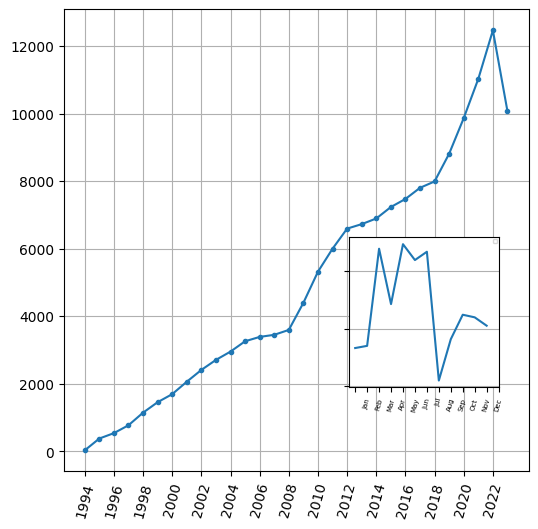

In [10]:
fig, ax = plt.subplots(figsize=(6,6))
# fig.set_size_inches(3.54,3.54)

ax.plot( np.arange(len(numpapers_y)), numpapers_y, '-o', markersize=3 )

ax.set_xticks( list(range(len(years))[::2]))
ax.set_xticklabels( years[::2], rotation=75 )

ax.grid()

ax2 = fig.add_axes([0.6, 0.25, 0.25, 0.25])

ax2.plot(np.arange(len(numpapers_m)), numpapers_m)
ax2.legend(fancybox=True, ncol=2, prop={'size':3})
ax2.set_xticks( range(13) )
ax2.set_xticklabels( ["", "Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"], rotation=75, fontsize=5 )
ax2.set_yticklabels([])
ax2.yaxis.grid(True)